# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» хочет разработать систему, которая будет способна привлекать больше водителей в аэропорт в период пиковой нагрузки. Для решения этой задачи нужно спрогнозировать количество заказов такси на следующий час.

## Данные

Данные лежат в файле `/datasets/taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

## Задача

Построить модель машинного обучения, которая будет прогнозировать количесвто заказаов на час вперёд, обучив её исторических данных, продоставленных компанией "Чётенькое такси". При этом метрика проверки качества модели $RMSE$ должна быть не больше 48.

In [ ]:
!pip install -q statsmodels

## Загрузка данных

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

import time
import warnings

In [ ]:
TEST_SIZE = 0.1
RANDOM_STATE = 42

In [ ]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем индексы

In [ ]:
data = data.sort_index()

Проверим последовательность рядов

In [ ]:
data.isna().sum()

num_orders    0
dtype: int64

In [ ]:
data.index.is_monotonic_increasing

True

Ресемплируем по одному часу

In [ ]:
data=data.resample('1H').sum()

## Анализ данных

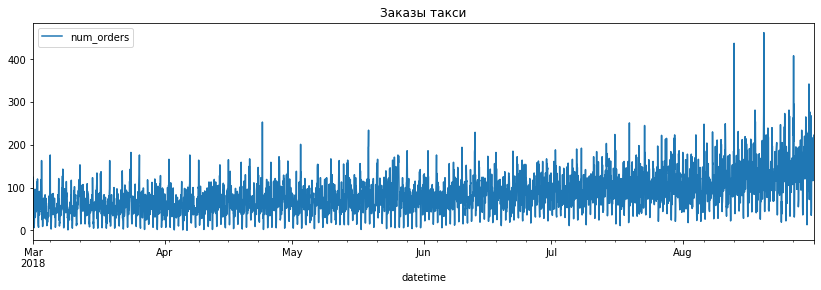

In [ ]:
plt.figure(figsize=(14, 4))
plt.title("Заказы такси")
data.plot(ax=plt.gca())
plt.show()

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
print(f'Начало периода: {data.index.min()}')
print(f'Конец периода: {data.index.max()}')

Начало периода: 2018-03-01 00:00:00
Конец периода: 2018-08-31 23:00:00


Данные представлены с 1 марта 2018 по 31 августа 2018

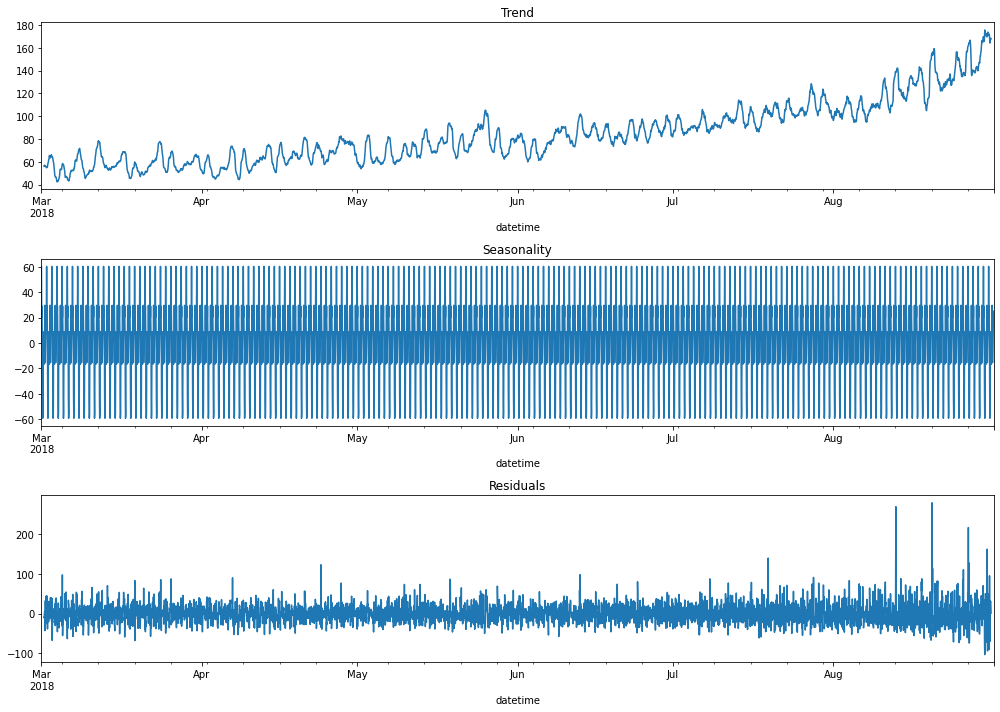

In [ ]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(14, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Из графиков видно, что количество заказов росло в течение полугода. Сезонность мы рассмотрим в промежутке двух недель августа

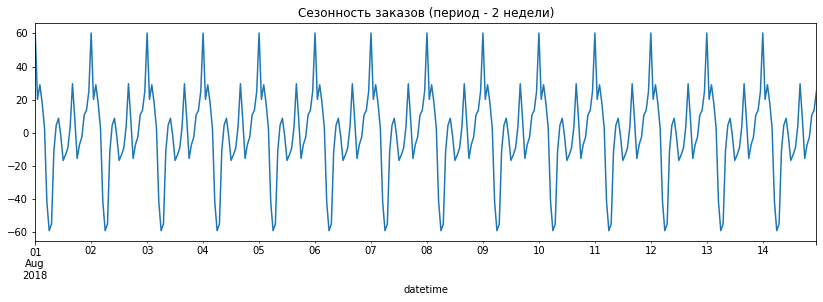

In [ ]:
plt.figure(figsize=(14, 4))
plt.title("Сезонность заказов (период - 2 недели)")
decomposed.seasonal['2018-08-01':'2018-08-14'].plot(ax=plt.gca())
plt.show()

Временной ряд стационарный, так как среднее значение и стандартное отклонение не меняется

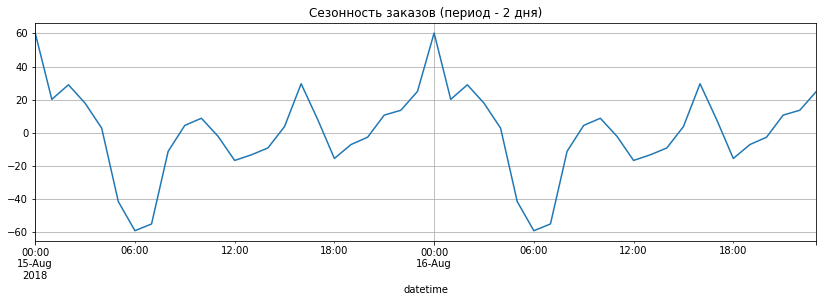

In [ ]:
plt.figure(figsize=(14, 4))
plt.title("Сезонность заказов (период - 2 дня)")
decomposed.seasonal['2018-08-15':'2018-08-16'].plot(ax=plt.gca(), grid=True)
plt.show()

Большинство заказов приходится на полночь, скорее всего, большее количество рейсов - ночные. Утренних заказов в 6 часов совсем мало. Рост наблюдается с 18:00 по 00:00 и с 12:00 по 17:00.

## Обучение модели

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(data, 24, 24)

In [ ]:
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train, test = train_test_split(
    data,
    shuffle=False,
    test_size=TEST_SIZE
)

Обучать модель с пропусками в данных нельзя, поэтому их придется удалить

In [ ]:
train = train.dropna()

In [ ]:
X_train = train.drop(['num_orders'], axis = 1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis = 1)
y_test = test['num_orders']

Создадим функцию для кроссвалидации моделей

In [ ]:
def choose_model(model, parameters, n_split):
    time_series = TimeSeriesSplit(n_splits=n_split)
    grid_search = GridSearchCV(
        model,
        parameters,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        cv=time_series
    )
    grid_search.fit(X_train, y_train)

    start = time.time()
    predict = grid_search.predict(X_train)
    end = time.time() - start

    print('Метрика лучшей модели на обучающей выборке:', grid_search.best_score_ * -1)
    return grid_search.best_score_ * -1, grid_search, end

### CatBoostRegressor

In [ ]:
cb_param_grid = {
    'iterations': [150, 200],
    'learning_rate': [0.05, 0.1]
}

In [ ]:
cb_rmse, cb_model, cb_time = choose_model(CatBoostRegressor(verbose=200, random_state=RANDOM_STATE), cb_param_grid, 5)

0:	learn: 28.9938410	total: 51.6ms	remaining: 7.7s
149:	learn: 11.9957843	total: 572ms	remaining: 0us
0:	learn: 29.7126090	total: 5.88ms	remaining: 876ms
149:	learn: 14.4620698	total: 643ms	remaining: 0us
0:	learn: 31.2844477	total: 6.17ms	remaining: 919ms
149:	learn: 15.8808186	total: 696ms	remaining: 0us
0:	learn: 32.6350799	total: 6.09ms	remaining: 908ms
149:	learn: 17.2672498	total: 780ms	remaining: 0us
0:	learn: 34.0046735	total: 6.13ms	remaining: 914ms
149:	learn: 18.3554894	total: 804ms	remaining: 0us
0:	learn: 28.3153152	total: 3.64ms	remaining: 543ms
149:	learn: 8.5388558	total: 507ms	remaining: 0us
0:	learn: 29.1149933	total: 6.85ms	remaining: 1.02s
149:	learn: 11.2636862	total: 653ms	remaining: 0us
0:	learn: 30.5702732	total: 4.71ms	remaining: 703ms
149:	learn: 13.2631108	total: 692ms	remaining: 0us
0:	learn: 31.9045871	total: 5.29ms	remaining: 789ms
149:	learn: 14.6283858	total: 783ms	remaining: 0us
0:	learn: 33.2308376	total: 5.81ms	remaining: 865ms
149:	learn: 15.8680648	

### DecisionTreeRegressor

In [ ]:
dt_param_grid = {'max_depth': range (1, 8),
           'min_samples_leaf': range (1, 8),
           'min_samples_split': range (2, 5)}

In [ ]:
dt_rmse, dt_model, dt_time = choose_model(DecisionTreeRegressor(), dt_param_grid, 5)

Метрика лучшей модели на обучающей выборке: 29.31878333212337


### LightGBMRegressor

In [ ]:
lgbm_param_grid = {'num_leaves': [150, 200],
                   'learning_rate': [0.05, 0.1]}

In [ ]:
lgbm_rmse, lgbm_model, lgbm_time = choose_model(LGBMRegressor(random_state=RANDOM_STATE, verbose=-1), lgbm_param_grid, 5)

Метрика лучшей модели на обучающей выборке: 24.996961293781986


In [ ]:
results = pd.DataFrame({
    'DecisionTreeRegressor': [dt_rmse, dt_time],
    'CatBoostRegressor': [cb_rmse, cb_time],
    'LGBMRegressor': [lgbm_rmse, lgbm_time]
}, index=['Метрика RMSE', 'Время предсказания'])

In [ ]:
results.T

,Метрика RMSE,Время предсказания
DecisionTreeRegressor,29.318783,0.002115
CatBoostRegressor,24.607985,0.003016
LGBMRegressor,24.996961,0.104820


По итогам обучения и предсказания, лучшей моделью с точки зрения метрики и времени предсказания оказалась модель CatBoostRegressor

### Предсказание на тестовой выборке

In [ ]:
predictions = cb_model.predict(X_test)

In [ ]:
test_score = mean_squared_error(y_test, predictions, squared=False)

In [ ]:
print('RMSE лучшей модели:', test_score)

RMSE лучшей модели: 42.77141426863502


Метрика RMSE соответствует условиям заказчика. Построим график, на котором изобразим тестовые данные и предсказания

In [ ]:
y_pred = pd.Series(predictions, index=y_test.index)

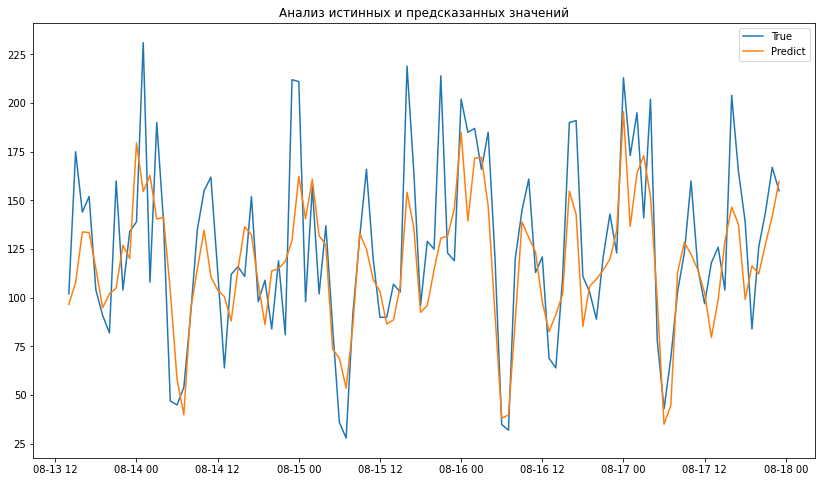

In [ ]:
plt.figure(figsize=(14, 8))

plt.plot(y_test['2018-08-13':'2018-08-17'], label='True')
plt.plot(y_pred['2018-08-13':'2018-08-17'], label='Predict')

plt.title('Анализ истинных и предсказанных значений')
plt.legend()
plt.show()

## Вывод

1. Мы загрузили данные из .csv файла и передали аргумент `parse_dates` и `index_col`. Выяснили, что датасет состоит из 26496 строк и 1 столбца - `num_orders`
2. Отсортировали индексы и обнаружили отсутствие пропусков. Ряд был монотонным
3. Ресемплировали по одному часу и вывели тренд, сезонность и остатки
4. Добавили новые признаки: число столбцов увеличилось до 30
5. Обучили три модели на кросс-валидации: DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor
6. Посчитали метрики на кросс-валидационной выборке и сравнили. Результаты:
| Модель                 | Метрика RMSE | Время предсказания |
|------------------------|--------------|--------------------|
| DecisionTreeRegressor  | 29.318783    | 0.002256           |
| CatBoostRegressor      | 24.607985    | 0.002898           |
| LGBMRegressor          | 24.996961    | 0.105016           |


7. Самой лучшей моделью оказалась CatBoostRegressor. **Метрика RMSE на тестовой выборке - 42.77**

Важно отметить, что время предсказания для CatBoostRegressor и DecisionTreeRegressor оказалось примерно одинаковым, но для LGBMRegressor время предсказания чуть больше. Это может быть важным фактором при выборе модели для конкретного применения, особенно если скорость предсказания имеет значение.